## Problem Statement
We would like to solve a (boundary value problem) BVP for the 1D heat equation
$$
u_t(t,x) = u_{xx}(t, x), \quad t\in [0,6], \quad x\in [-1,1]
$$
where the subscripts describe the first or second order partial derivatives. Together with this partial differential equation (PDE), we have boundary and initial conditions.
$$
u(t,-1) = u(t,1) = 0\\
u(0,x) = -\sin(\pi x)
$$
Our goal is now to approximate the function $u(t,x)$ by a neural network $u(t,x)\approx NN_\theta(t,x)$, which we can do by using auto-differentiation and a suitable optimization target that ensures that the PDE, initial condition and boundary conditions are fulfilled:
$$
\begin{align}
\bm{\theta}^\star &= \argmin_{\bm{\theta}} \underbrace{||\frac{\partial}{\partial t} NN_{\theta}(t,x) - \frac{\partial^2}{\partial x^2} NN_{\theta}(t,x)||^2}_{\text{PDE}} \\ 
&+ \underbrace{||NN_{\theta}(t,-1) - 0||^2 + ||NN_{\theta}(t,1) - 0||^2}_{\text{boundary conditions}}\\
&+ \underbrace{||NN_{\theta}(0,x) + sin(\pi x)||^2}_{\text{initial condition}}
\end{align}
$$
## Defining the Evaluation Grid
Let us first generate the points on which we train our neural network, i.e. evaluate the loss from above. Here we just generate those points uniformly, usually it is advisable to use more sophisticated methods such as random sampling or [Sobol sequences](https://en.wikipedia.org/wiki/Sobol_sequence).

Text(0, 0.5, 'x')

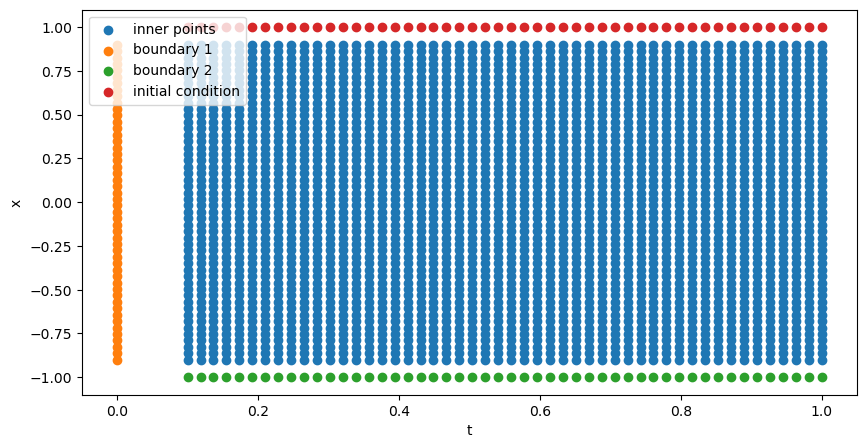

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

x = torch.linspace(-0.9,0.9,50)
t = torch.linspace(0.1,1,50)

inner = torch.cartesian_prod(t, x)

spat_boundary1 = torch.zeros((t.shape[0], 2))
spat_boundary1[:,0] = t
spat_boundary1[:,1] = -1

spat_boundary2 = torch.zeros((t.shape[0], 2))
spat_boundary2[:,0] = t
spat_boundary2[:,1] = 1

temp_boundary = torch.zeros((x.shape[0], 2))
temp_boundary[:,0] = 0
temp_boundary[:,1] = x

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(inner[:,0], inner[:,1], label="inner points")
ax.scatter(temp_boundary[:,0], temp_boundary[:,1], label="boundary 1")
ax.scatter(spat_boundary1[:,0], spat_boundary1[:,1], label="boundary 2")
ax.scatter(spat_boundary2[:,0], spat_boundary2[:,1], label="initial condition")
ax.legend()
ax.set_xlabel("t")
ax.set_ylabel("x")

## Defining the Loss Function
The loss functions for the boundary and initial points are very straightforward, the PDE loss requires familiarity with directly tapping into PyTorch's `autograd` functionality.

In [27]:
def calc_boundary_loss(preds, coords):
    return F.mse_loss(preds, -torch.sin(np.pi * coords[:,1]))

def calc_init_loss(preds, coords):
    return F.mse_loss(preds, torch.zeros_like(preds))

def calc_total_loss(nn, inner, boundary1, boundary2, init):
    inner.requires_grad = True
    pred_inner = nn(inner)
    pred_inner_grad = torch.autograd.grad(pred_inner.sum(), inner, create_graph=True)[0]
    u_t = pred_inner_grad[:,0]
    u_x = pred_inner_grad[:,1]
    u_xx = torch.autograd.grad(u_x.sum(), inner, create_graph=True)[0][:,1]

    inner_loss = F.mse_loss(u_t, u_xx)
    boundary_loss = calc_boundary_loss(nn(boundary1), boundary1)
    boundary_loss += calc_boundary_loss(nn(boundary2), boundary2)
    boundary_loss /= 2
    init_loss = calc_init_loss(nn(init), init)

    return inner_loss + 10000*boundary_loss + 10000*init_loss

## Defining the Neural Network and Training

In [28]:
u = nn.Sequential(
    nn.Linear(2,64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64,1)
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/h9/96x2b9pn2_v_xfb0gsxn97mw0000gn/T/ipykernel_85023/3507851442.py:2: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(preds, -torch.sin(np.pi * coords[:,1]))


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


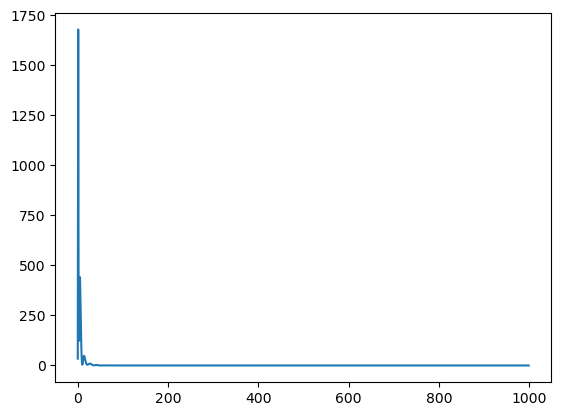

In [29]:
optim = torch.optim.Adam(u.parameters(), lr=0.01)

losses = []
for i in range(1000):
    optim.zero_grad()
    loss = calc_total_loss(u, inner, spat_boundary1, spat_boundary2, temp_boundary)
    loss.backward()
    optim.step()
    losses.append(loss.item())

plt.plot(losses)

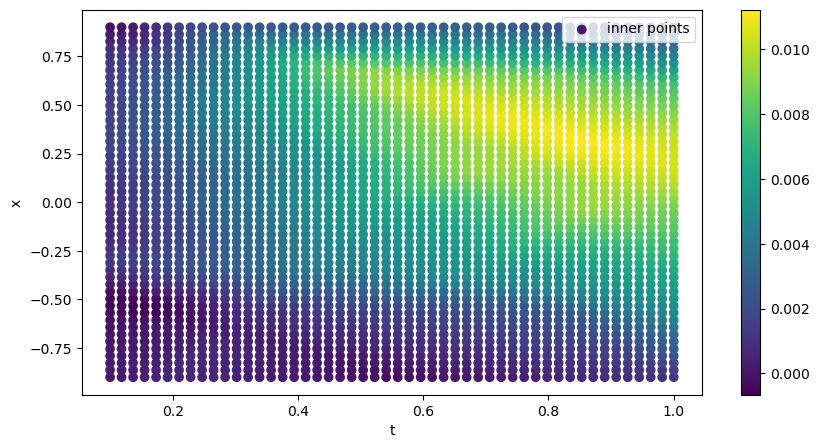

In [30]:
preds = u(inner)

fig, ax = plt.subplots(figsize=(10,5))
out = ax.scatter(inner[:,0].detach(), inner[:,1].detach(), c=preds.detach().squeeze(), label="inner points")
ax.legend()
ax.set_xlabel("t")
ax.set_ylabel("x")
plt.colorbar(out)